## Setup and Data Loading

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install --quiet seaborn
import seaborn as sns
from datetime import datetime
import re
import json
import ast
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Display Option
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Load the dataset
listing_data = pd.read_csv('listings.csv')

## Intial Data Exploration

In [41]:
# Intial Look at the Data Set
listing_data.info()

# Missing Values 
missing_data = listing_data.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_data / len(listing_data)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_pct
}).round(2)

print(missing_df[missing_df['Missing Count'] > 0].head(20))

# Data Types
print(listing_data.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7151 entries, 0 to 7150
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7151 non-null   int64  
 1   listing_url                                   7151 non-null   object 
 2   scrape_id                                     7151 non-null   int64  
 3   last_scraped                                  7151 non-null   object 
 4   source                                        7151 non-null   object 
 5   name                                          7151 non-null   object 
 6   description                                   6985 non-null   object 
 7   neighborhood_overview                         2793 non-null   object 
 8   picture_url                                   7151 non-null   object 
 9   host_id                                       7151 non-null   i

In [42]:
# Statsistical Summary 
numeric_cols = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                'number_of_reviews', 'review_scores_rating']
if all(col in listing_data.columns for col in numeric_cols):
    print(listing_data[numeric_cols].describe())

       accommodates     bedrooms         beds    bathrooms  number_of_reviews  \
count   7151.000000  6930.000000  6289.000000  6293.000000        7151.000000   
mean       3.899175     1.838384     2.316585     1.411648          32.843239   
std        2.612137     1.292707     1.933150     0.732919          77.592638   
min        1.000000     0.000000     0.000000     0.000000           0.000000   
25%        2.000000     1.000000     1.000000     1.000000           1.000000   
50%        4.000000     1.000000     2.000000     1.000000           8.000000   
75%        5.000000     2.000000     3.000000     2.000000          33.000000   
max       16.000000    50.000000    50.000000    19.000000        3231.000000   

       review_scores_rating  
count           5677.000000  
mean               4.677419  
std                0.525511  
min                1.000000  
25%                4.620000  
50%                4.830000  
75%                4.990000  
max                5.000000  


## Data Cleaning and Pre Processing

### Remove High-Missing Columns

In [43]:
# Dropping columns with over 50% missing data
columns_to_drop = [
    'calendar_updated', 'license', 'host_neighbourhood', 
    'neighborhood_overview', 'host_about', 'scrape_id'
]

columns_to_drop = [col for col in columns_to_drop if col in listing_data.columns]
listing_data = listing_data.drop(columns=columns_to_drop)

### Clean Price and Percentage Columns

In [44]:
def clean_price(price_str):
    """Clean price column by removing $ and commas and convert to numeric"""
    if pd.isna(price_str):
        return np.nan
    try:
        return float(str(price_str).replace('$', '').replace(',', ''))
    except:
        return np.nan

def clean_percentage(pct_str):
    """Clean percentage columns by removing % and convert to numeric"""
    if pd.isna(pct_str) or pct_str == 'N/A':
        return np.nan
    try:
        return float(str(pct_str).replace('%', ''))
    except:
        return np.nan

# Apply cleaning functions
if 'price' in listing_data.columns:
    listing_data['price'] = listing_data['price'].apply(clean_price)

percentage_cols = ['host_response_rate', 'host_acceptance_rate']
for col in percentage_cols:
    if col in listing_data.columns:
        listing_data[col] = listing_data[col].apply(clean_percentage)

### Handle Boolean Columns

In [45]:
# Convert booleans
boolean_columns = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
    'has_availability', 'instant_bookable'
]

for col in boolean_columns:
    if col in listing_data.columns:
        # Handle various boolean representations
        listing_data[col] = listing_data[col].map({
            't': True, 'f': False, 
            'true': True, 'false': False,
            True: True, False: False
        })

### Handle Missing Values

In [46]:
# Fill missing numeric values with median
numeric_fill_cols = ['bathrooms', 'bedrooms', 'beds']
for col in numeric_fill_cols:
    if col in listing_data.columns:
        median_val = listing_data[col].median()
        listing_data[col] = listing_data[col].fillna(median_val)

# Fill categorical missing values
categorical_fills = {
    'host_response_time': 'unknown',
    'host_response_rate': 0,
    'host_acceptance_rate': 0
}

for col, fill_value in categorical_fills.items():
    if col in listing_data.columns:
        listing_data[col] = listing_data[col].fillna(fill_value)

# Fill boolean columns with False for missing values
for col in boolean_columns:
    if col in listing_data.columns:
        listing_count = listing_data[col].isnull().sum()
        listing_data[col] = listing_data[col].fillna(False)

### Date Processing

In [47]:
# Convert date columns
date_columns = [
    'last_scraped', 'host_since', 'calendar_last_scraped', 
    'first_review', 'last_review'
]

for col in date_columns:
    if col in listing_data.columns:
        listing_data[col] = pd.to_datetime(listing_data[col], errors='coerce')

## Feature Engineering

### Create Derived Features

In [48]:
# Host since 
if 'host_since' in listing_data.columns and 'last_scraped' in listing_data.columns:
    listing_data['host_days_active'] = (
        listing_data['last_scraped'] - listing_data['host_since']
    ).dt.days
    listing_data['host_years_active'] = listing_data['host_days_active'] / 365.25

# Days since last review
if 'last_review' in listing_data.columns and 'last_scraped' in listing_data.columns:
    listing_data['days_since_last_review'] = (
        listing_data['last_scraped'] - listing_data['last_review']
    ).dt.days

# Price per person
if 'price' in listing_data.columns and 'accommodates' in listing_data.columns:
    listing_data['price_per_person'] = listing_data['price'] / listing_data['accommodates']

# Availability features
if 'availability_30' in listing_data.columns:
    listing_data['availability_rate_30'] = listing_data['availability_30'] / 30
    
if 'availability_365' in listing_data.columns:
    listing_data['availability_rate_365'] = listing_data['availability_365'] / 365

# Reviews 
if all(col in listing_data.columns for col in ['number_of_reviews', 'host_days_active']):
    listing_data['reviews_per_month'] = (
        listing_data['number_of_reviews'] / 
        np.maximum(listing_data['host_days_active'] / 30, 1)
    )

# People per bedroom 
if all(col in listing_data.columns for col in ['bedrooms', 'accommodates']):
    listing_data['people_per_bedroom'] = listing_data['accommodates'] / np.maximum(listing_data['bedrooms'], 1)

### Handle Outliers

In [49]:
def handle_outliers(df, column, method='clip', lower_pct=0.01, upper_pct=0.99):
    """Handle outliers using IQR """
    if column not in df.columns:
        return df
    
    if method == 'clip':
        lower_bound = df[column].quantile(lower_pct)
        upper_bound = df[column].quantile(upper_pct)
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Handle price outliers
if 'price' in listing_data.columns:
    
    listing_data = handle_outliers(listing_data, 'price', method='clip', lower_pct=0.01, upper_pct=0.99)

# Handle other numeric outliers
numeric_outlier_cols = ['accommodates', 'bedrooms', 'beds', 'bathrooms']
for col in numeric_outlier_cols:
    if col in listing_data.columns:
        listing_data = handle_outliers(listing_data, col, upper_pct=0.95)

### Text Feature Extraction

In [50]:
# Amenities Processing
def parse_amenities(amenities_str):
    """Parse amenities string into list"""
    if pd.isna(amenities_str):
        return []
    try:
        # Different Formats 
        if amenities_str.startswith('['):
            return ast.literal_eval(amenities_str)
        else:
            # Split by comma
            return [item.strip().strip('"\'') for item in amenities_str.split(',')]
    except:
        return []

def has_amenity(amenities_list, amenity):
    """Check for partial matchs and case sentivties"""
    if not amenities_list:
        return False
    amenity_lower = amenity.lower()
    return any(amenity_lower in item.lower() for item in amenities_list)

# Parse amenities
listing_data['amenities_list'] = listing_data['amenities'].apply(parse_amenities)
listing_data['amenities_count'] = listing_data['amenities_list'].apply(len)

# Create binary features for important amenities
important_amenities = [
    'Wifi', 'Kitchen', 'Air conditioning', 'Heating', 'Washer', 'Dryer',
    'Free parking', 'Gym', 'Pool', 'Hot tub', 'Breakfast', 'Laptop friendly',
    'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Essentials',
    'Shampoo', 'Hair dryer', 'Iron', 'Hangers', 'Self check-in',
    'Keypad', 'Lockbox', 'Private entrance', 'Dedicated workspace'
]

for amenity in important_amenities:
    col_name = f"has_{amenity.lower().replace(' ', '_').replace('-', '_')}"
    listing_data[col_name] = listing_data['amenities_list'].apply(
        lambda x: has_amenity(x, amenity)
    )

# Amenity categories
tech_amenities = ['wifi', 'internet', 'wireless_internet', 'tv', 'cable_tv', 'laptop_friendly']
comfort_amenities = ['air_conditioning', 'heating', 'essentials', 'shampoo', 'hair_dryer']
convenience_amenities = ['kitchen', 'washer', 'dryer', 'free_parking', 'self_check_in']
luxury_amenities = ['gym', 'pool', 'hot_tub', 'breakfast', 'dedicated_workspace']

listing_data['tech_amenities_count'] = listing_data[[f'has_{a}' for a in tech_amenities]].sum(axis=1)
listing_data['comfort_amenities_count'] = listing_data[[f'has_{a}' for a in comfort_amenities]].sum(axis=1)
listing_data['convenience_amenities_count'] = listing_data[[f'has_{a}' for a in convenience_amenities]].sum(axis=1)
listing_data['luxury_amenities_count'] = listing_data[[f'has_{a}' for a in luxury_amenities]].sum(axis=1)

# Name processing
def extract_name_features(name):
    """Extract features from listing name"""
    if pd.isna(name):
        return {
            'name_length': 0, 'name_word_count': 0, 'name_luxury_score': 0,
            'name_location_score': 0, 'name_mentions_apartment': False,
            'name_mentions_house': False, 'name_mentions_studio': False,
            'name_mentions_loft': False, 'name_mentions_room': False,
            'name_comfort_score': 0, 'name_mentions_private': False,
            'name_mentions_entire': False, 'name_view_score': 0
        }
    
    name_lower = str(name).lower()
    
    features = {}
    
    # Length and word count
    features['name_length'] = len(name)
    features['name_word_count'] = len(name.split())
    
    # Luxury indicators
    luxury_words = ['luxury', 'premium', 'deluxe', 'executive', 'penthouse', 'villa', 'mansion']
    features['name_luxury_score'] = sum(1 for word in luxury_words if word in name_lower)
    
    # Location indicators
    location_words = ['central', 'downtown', 'city center', 'heart of', 'near', 'close to', 'walking distance']
    features['name_location_score'] = sum(1 for word in location_words if word in name_lower)
    
    # Property type indicators
    features['name_mentions_apartment'] = 'apartment' in name_lower or 'flat' in name_lower
    features['name_mentions_house'] = 'house' in name_lower or 'home' in name_lower
    features['name_mentions_studio'] = 'studio' in name_lower
    features['name_mentions_loft'] = 'loft' in name_lower
    features['name_mentions_room'] = 'room' in name_lower and 'bedroom' not in name_lower
    
    # Comfort indicators
    comfort_words = ['cozy', 'comfortable', 'spacious', 'bright', 'modern', 'stylish', 'beautiful']
    features['name_comfort_score'] = sum(1 for word in comfort_words if word in name_lower)
    
    # Privacy indicators
    features['name_mentions_private'] = 'private' in name_lower
    features['name_mentions_entire'] = 'entire' in name_lower
    
    # View indicators
    view_words = ['view', 'garden', 'balcony', 'terrace', 'sea', 'ocean', 'mountain', 'city view']
    features['name_view_score'] = sum(1 for word in view_words if word in name_lower)
    
    return features

# Apply name feature extraction
name_features = listing_data['name'].apply(extract_name_features)
name_features_df = pd.json_normalize(name_features)
name_features_df.index = listing_data.index

# Add to main dataframe
for col in name_features_df.columns:
    listing_data[col] = name_features_df[col]

# Description Processing 
def simple_readability_score(text):
    """Readability approximation """
    if pd.isna(text) or len(str(text).strip()) == 0:
        return 0
    
    text_str = str(text)
    sentences = len([s for s in text_str.split('.') if s.strip()])
    words = len(text_str.split())
    
    if sentences == 0 or words == 0:
        return 0
    
    # Simplified score
    avg_sentence_length = words / sentences
    avg_word_length = sum(len(word) for word in text_str.split()) / words
    
    # Simple approximation 
    readability = 100 - (1.015 * avg_sentence_length) - (84.6 * (avg_word_length / 5))
    return max(0, min(100, readability))

def simple_sentiment_score(text):
    """Sentiment analysis """
    if pd.isna(text):
        return 0
    
    text_lower = str(text).lower()
    
    # Positive words
    positive_words = [
        'amazing', 'beautiful', 'perfect', 'excellent', 'wonderful', 'fantastic', 
        'great', 'awesome', 'lovely', 'stunning', 'spectacular', 'incredible',
        'comfortable', 'cozy', 'charming', 'peaceful', 'relaxing', 'enjoyable',
        'convenient', 'spacious', 'bright', 'clean', 'modern', 'stylish'
    ]
    
    # Negative words  
    negative_words = [
        'terrible', 'awful', 'bad', 'horrible', 'disappointing', 'dirty',
        'noisy', 'uncomfortable', 'small', 'cramped', 'old', 'outdated',
        'inconvenient', 'difficult', 'problems', 'issues', 'broken'
    ]
    
    positive_count = sum(1 for word in positive_words if word in text_lower)
    negative_count = sum(1 for word in negative_words if word in text_lower)
    
    # Simple compound score
    total_words = len(text_lower.split())
    if total_words == 0:
        return 0
    
    sentiment_score = (positive_count - negative_count) / max(total_words / 10, 1)
    return max(-1, min(1, sentiment_score))

def extract_description_features(description):
    """Extract features from description"""
    if pd.isna(description):
        return {
            'desc_length': 0, 'desc_word_count': 0, 'desc_sentence_count': 0,
            'avg_word_length': 0, 'desc_char_diversity': 0, 'desc_readability': 0,
            'desc_sentiment_score': 0, 'desc_emotional_score': 0, 'desc_location_mentions': 0,
            'desc_transport_mentions': 0, 'desc_experience_score': 0, 'desc_facility_mentions': 0,
            'desc_business_score': 0, 'desc_safety_mentions': 0, 'desc_cleanliness_score': 0,
            'desc_urgency_score': 0, 'desc_capitals_ratio': 0, 'desc_exclamation_count': 0
        }
    
    desc_str = str(description)
    desc_lower = desc_str.lower()
    words = desc_str.split()
    
    features = {}
    
    # Basic text statistics
    features['desc_length'] = len(desc_str)
    features['desc_word_count'] = len(words)
    features['desc_sentence_count'] = len([s for s in desc_str.split('.') if s.strip()])
    features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0
    
    # Character diversity
    unique_chars = len(set(desc_str.lower()))
    features['desc_char_diversity'] = unique_chars / len(desc_str) if len(desc_str) > 0 else 0
    
    # Readability and sentiment 
    features['desc_readability'] = simple_readability_score(desc_str)
    features['desc_sentiment_score'] = simple_sentiment_score(desc_str)
    
    # Emotional language
    emotional_words = ['love', 'perfect', 'amazing', 'beautiful', 'wonderful', 'fantastic', 'great', 'excellent']
    features['desc_emotional_score'] = sum(1 for word in emotional_words if word in desc_lower)
    
    # Location mentions
    location_words = ['location', 'neighborhood', 'area', 'district', 'close', 'near', 'walking', 'minutes']
    features['desc_location_mentions'] = sum(1 for word in location_words if word in desc_lower)
    
    # Transportation mentions
    transport_words = ['metro', 'subway', 'bus', 'train', 'station', 'transport', 'uber', 'taxi']
    features['desc_transport_mentions'] = sum(1 for word in transport_words if word in desc_lower)
    
    # Experience words
    experience_words = ['experience', 'enjoy', 'relax', 'explore', 'discover', 'adventure', 'stay']
    features['desc_experience_score'] = sum(1 for word in experience_words if word in desc_lower)
    
    # Facility mentions
    facility_words = ['kitchen', 'bathroom', 'bedroom', 'living', 'dining', 'balcony', 'garden', 'parking']
    features['desc_facility_mentions'] = sum(1 for word in facility_words if word in desc_lower)
    
    # Business/professional language
    business_words = ['professional', 'business', 'work', 'workspace', 'office', 'meetings']
    features['desc_business_score'] = sum(1 for word in business_words if word in desc_lower)
    
    # Safety mentions
    safety_words = ['safe', 'secure', 'security', 'safety', 'protected', 'gated']
    features['desc_safety_mentions'] = sum(1 for word in safety_words if word in desc_lower)
    
    # Cleanliness mentions
    clean_words = ['clean', 'fresh', 'spotless', 'sanitized', 'hygienic']
    features['desc_cleanliness_score'] = sum(1 for word in clean_words if word in desc_lower)
    
    # Urgency/scarcity language
    urgency_words = ['book now', 'limited', 'rare', 'unique', 'exclusive', 'special']
    features['desc_urgency_score'] = sum(1 for word in urgency_words if word in desc_lower)
    
    # Capital letters ratio (might indicate enthusiasm)
    capitals = sum(1 for char in desc_str if char.isupper())
    features['desc_capitals_ratio'] = capitals / len(desc_str) if len(desc_str) > 0 else 0
    
    # Exclamation marks (enthusiasm indicator)
    features['desc_exclamation_count'] = desc_str.count('!')
    
    return features

# Apply description feature extraction
desc_features = listing_data['description'].apply(extract_description_features)
desc_features_df = pd.json_normalize(desc_features)
desc_features_df.index = listing_data.index

# Add to main dataframe
for col in desc_features_df.columns:
    listing_data[col] = desc_features_df[col]

# Theme Analysis 

# Theme categories
theme_categories = {
    'luxury_themes': ['luxury', 'premium', 'elegant', 'sophisticated', 'upscale', 'high-end'],
    'location_themes': ['central', 'downtown', 'city', 'center', 'heart', 'convenient'],
    'comfort_themes': ['comfortable', 'cozy', 'warm', 'relaxing', 'peaceful', 'quiet'],
    'space_themes': ['spacious', 'large', 'big', 'roomy', 'open', 'bright'],
    'amenity_themes': ['kitchen', 'bathroom', 'wifi', 'parking', 'garden', 'balcony'],
    'experience_themes': ['perfect', 'ideal', 'great', 'wonderful', 'amazing', 'excellent']
}

def calculate_theme_scores(text, theme_words):
    """Calculate theme presence score"""
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return sum(1 for word in theme_words if word in text_lower)

# Add theme scores
for theme_name, theme_words in theme_categories.items():
    listing_data[f'desc_{theme_name}_score'] = listing_data['description'].apply(
        lambda x: calculate_theme_scores(x, theme_words)
    )

# Combinded Intelligence Score 
def calculate_text_intelligence_score(row):
    """Calculate overall score based on all text features"""
    score = 0
    
    # Name contribution (20% weight)
    name_score = (
        row.get('name_luxury_score', 0) * 3 +
        row.get('name_location_score', 0) * 2 +
        row.get('name_comfort_score', 0) * 2 +
        row.get('name_view_score', 0) * 1.5 +
        (1 if row.get('name_mentions_private', False) else 0) * 1.5
    )
    score += name_score * 0.2
    
    # Description contribution (40% weight)  
    desc_score = (
        row.get('desc_emotional_score', 0) * 2 +
        row.get('desc_experience_score', 0) * 1.5 +
        row.get('desc_cleanliness_score', 0) * 2 +
        row.get('desc_safety_mentions', 0) * 1.5 +
        (row.get('desc_sentiment_score', 0) + 1) * 5 +  # Normalize sentiment
        row.get('desc_luxury_themes_score', 0) * 2 +
        row.get('desc_comfort_themes_score', 0) * 1.5
    )
    score += desc_score * 0.4
    
    # Amenities contribution (40% weight)
    amenities_score = (
        row.get('luxury_amenities_count', 0) * 3 +
        row.get('convenience_amenities_count', 0) * 2 +
        row.get('tech_amenities_count', 0) * 1.5 +
        row.get('comfort_amenities_count', 0) * 1.5
    )
    score += amenities_score * 0.4
    
    return score

listing_data['text_intelligence_score'] = listing_data.apply(calculate_text_intelligence_score, axis=1)

# Create percentile rankings
listing_data['text_appeal_percentile'] = listing_data['text_intelligence_score'].rank(pct=True) * 100

# Create categorical appeal levels
def categorize_appeal(percentile):
    if percentile >= 90:
        return 'Premium'
    elif percentile >= 75:
        return 'High'
    elif percentile >= 50:
        return 'Medium'
    elif percentile >= 25:
        return 'Basic'
    else:
        return 'Low'

listing_data['text_appeal_category'] = listing_data['text_appeal_percentile'].apply(categorize_appeal)

## Exploratory Data Analysis

### Price Analysis

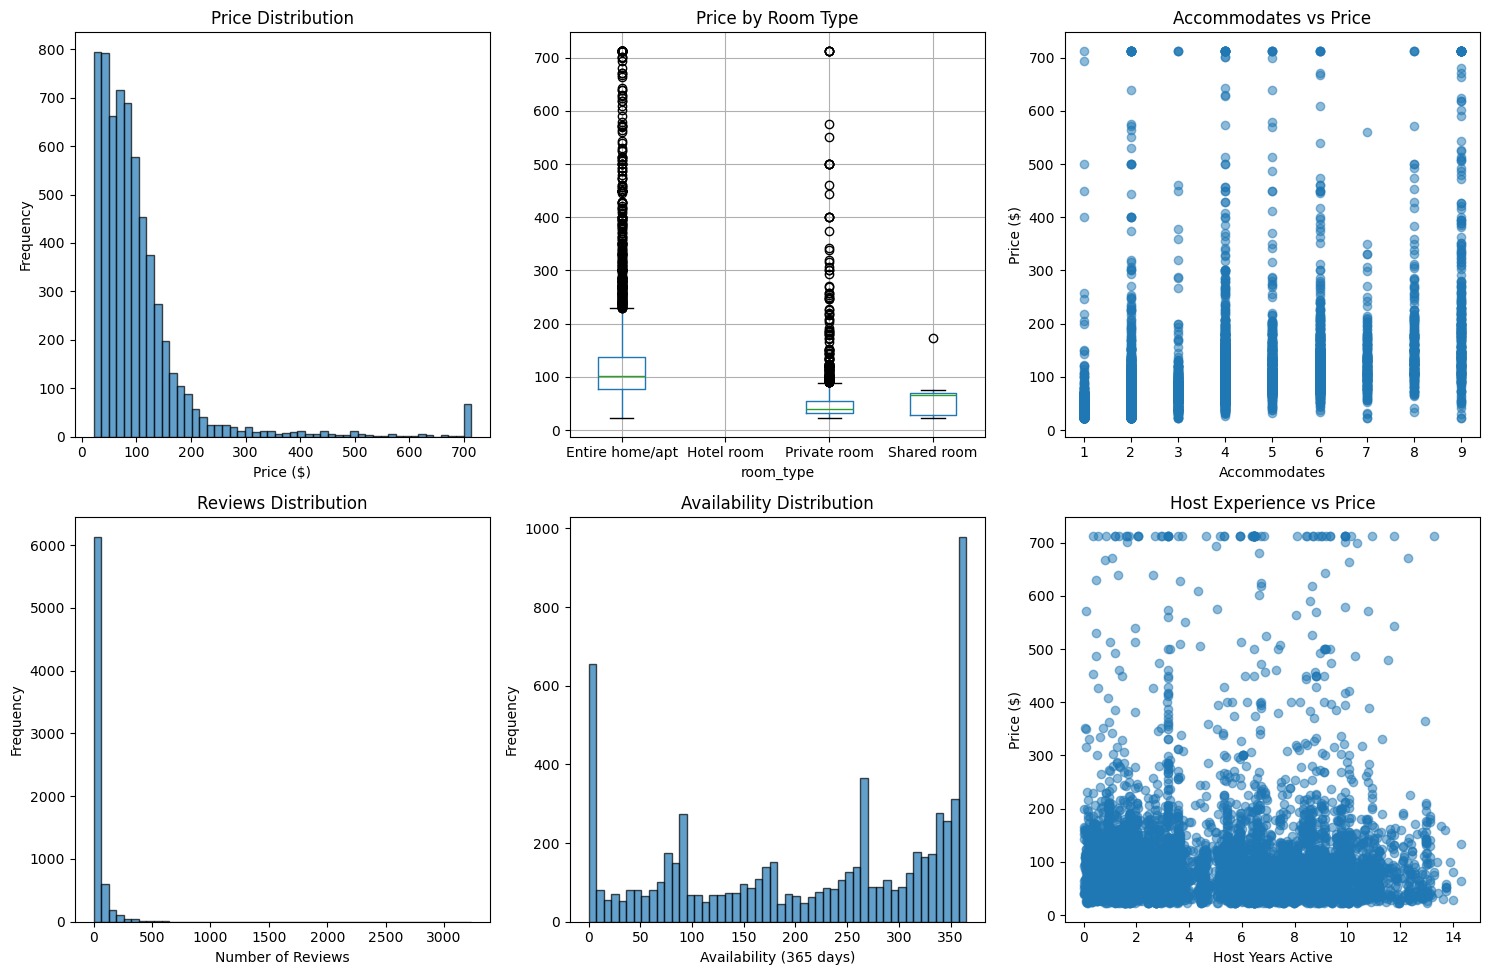

In [51]:
# Visulations
plt.figure(figsize=(15, 10))

# Price distribution
plt.subplot(2, 3, 1)
if 'price' in listing_data.columns:
    plt.hist(listing_data['price'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Price ($)')
    plt.ylabel('Frequency')
    plt.title('Price Distribution')

# Price by room type
plt.subplot(2, 3, 2)
if all(col in listing_data.columns for col in ['price', 'room_type']):
    listing_data.boxplot(column='price', by='room_type', ax=plt.gca())
    plt.title('Price by Room Type')
    plt.suptitle('')

# Accommodates vs Price
plt.subplot(2, 3, 3)
if all(col in listing_data.columns for col in ['accommodates', 'price']):
    plt.scatter(listing_data['accommodates'], listing_data['price'], alpha=0.5)
    plt.xlabel('Accommodates')
    plt.ylabel('Price ($)')
    plt.title('Accommodates vs Price')

# Reviews distribution
plt.subplot(2, 3, 4)
if 'number_of_reviews' in listing_data.columns:
    plt.hist(listing_data['number_of_reviews'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')
    plt.title('Reviews Distribution')

# Availability analysis
plt.subplot(2, 3, 5)
if 'availability_365' in listing_data.columns:
    plt.hist(listing_data['availability_365'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Availability (365 days)')
    plt.ylabel('Frequency')
    plt.title('Availability Distribution')

# Host experience vs Price
plt.subplot(2, 3, 6)
if all(col in listing_data.columns for col in ['host_years_active', 'price']):
    plt.scatter(listing_data['host_years_active'], listing_data['price'], alpha=0.5)
    plt.xlabel('Host Years Active')
    plt.ylabel('Price ($)')
    plt.title('Host Experience vs Price')

plt.tight_layout()
plt.show()

### Correlation Analysis

Top 15 Features Correlated with Price:
price                                          1.000000
accommodates                                   0.436089
bedrooms                                       0.409703
price_per_person                               0.394110
beds                                           0.364715
estimated_revenue_l365d                        0.284890
bathrooms                                      0.277909
host_total_listings_count                      0.254020
host_listings_count                            0.232199
people_per_bedroom                             0.136895
tech_amenities_count                           0.135192
days_since_last_review                         0.133581
maximum_nights                                 0.115850
name_luxury_score                              0.098089
calculated_host_listings_count_entire_homes    0.091713
Name: price, dtype: float64

Bottom 10 Features Correlated with Price:
number_of_reviews                              -0.

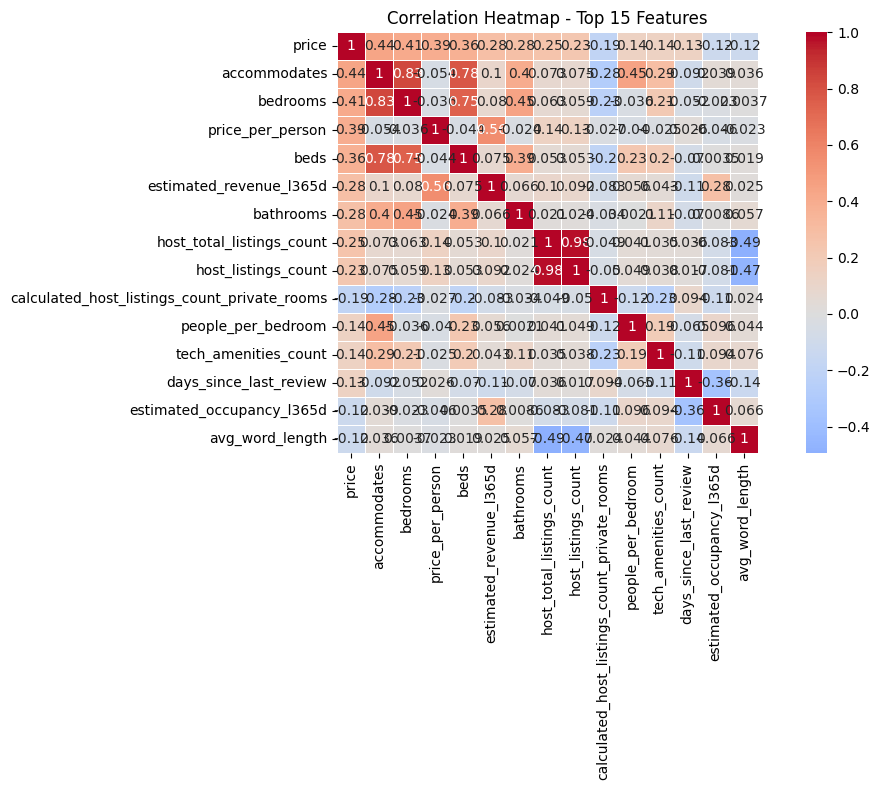

In [55]:
# Calculate correlations with price
if 'price' in listing_data.columns:
    numeric_cols = listing_data.select_dtypes(include=[np.number]).columns
    correlations = listing_data[numeric_cols].corr()['price'].sort_values(ascending=False)
    
    print("Top 15 Features Correlated with Price:")
    print(correlations.head(15))
    
    print("\nBottom 10 Features Correlated with Price:")
    print(correlations.tail(10))
    
    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    top_features = correlations.abs().nlargest(15).index
    corr_matrix = listing_data[top_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Correlation Heatmap - Top 15 Features')
    plt.tight_layout()
    plt.show()

## Model Prepartion

### Encode Categorical Variables

In [59]:
# Ordinal encoding for host response time
if 'host_response_time' in listing_data.columns:
    response_time_order = ['within an hour', 'within a few hours', 'within a day', 
                          'a few days or more', 'unknown']
    response_time_map = {v: i for i, v in enumerate(response_time_order)}
    listing_data['host_response_time_encoded'] = listing_data['host_response_time'].map(response_time_map)

# One-hot encoding for categorical variables
categorical_columns = []
for col in ['property_type', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'text_appeal_category']:
    if col in listing_data.columns:
        categorical_columns.append(col)


listing_data_encoded = listing_data.copy()

## Final Data Preparation

In [60]:
# Columns to drop for modeling
columns_to_drop_final = [
    'id', 'listing_url', 'scrape_id', 'source', 'picture_url', 
    'host_url', 'host_thumbnail_url', 'host_picture_url',
    'description', 'name', 'amenities', 'host_verifications',
    'host_name', 'neighbourhood', 'description_clean', 'name_clean', 
    'last_scraped','host_since', 'host_id', 'host_location', 
    'host_listings_count', 'bathrooms_text', 'minimum_nights', 
    'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights', 
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
    'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 
    'estimated_revenue_l365d', 'first_review', 'last_review', 'host_response_time',
    'amenities_list'
]

# Drop columns that exist
existing_drop_cols = [col for col in columns_to_drop_final if col in listing_data_encoded.columns]
df_model_ready = listing_data_encoded.drop(columns=existing_drop_cols)

print(f"Dropped {len(existing_drop_cols)} non-predictive columns")
print(f"Final dataset shape: {df_model_ready.shape}")

# Handle remaining missing values
print("\nRemaining missing values:")
missing_final = df_model_ready.isnull().sum()
print(missing_final[missing_final > 0])

# Fill or drop remaining missing values
df_model_ready = df_model_ready.dropna()
print(f"Final clean dataset shape: {df_model_ready.shape}")

Dropped 43 non-predictive columns
Final dataset shape: (7151, 37)

Remaining missing values:
neighborhood_overview          4358
host_about                     3845
host_response_rate              928
host_acceptance_rate            400
host_is_superhost               168
host_neighbourhood             6851
host_total_listings_count         2
host_has_profile_pic              2
host_identity_verified            2
bathrooms                       858
bedrooms                        221
beds                            862
price                           856
calendar_updated               7151
review_scores_rating           1474
review_scores_accuracy         1474
review_scores_cleanliness      1475
review_scores_checkin          1474
review_scores_communication    1474
review_scores_location         1474
review_scores_value            1474
license                        7151
reviews_per_month              1474
host_response_time_encoded      928
dtype: int64
Final clean dataset shape: (0,

### Data Type Optimization

In [132]:
# Optimize data types for memory efficiency
print("Optimizing data types...")
original_memory = df_model_ready.memory_usage(deep=True).sum() / 1024**2

for col in df_model_ready.columns:
    if df_model_ready[col].dtype == 'float64':
        df_model_ready[col] = pd.to_numeric(df_model_ready[col], downcast='float')
    elif df_model_ready[col].dtype == 'int64':
        df_model_ready[col] = pd.to_numeric(df_model_ready[col], downcast='integer')
    elif df_model_ready[col].dtype == 'bool':
        df_model_ready[col] = df_model_ready[col].astype('int8')

new_memory = df_model_ready.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage reduced from {original_memory:.2f} MB to {new_memory:.2f} MB")
print(f"Memory reduction: {((original_memory - new_memory) / original_memory) * 100:.1f}%")

Optimizing data types...
Memory usage reduced from 3.33 MB to 1.52 MB
Memory reduction: 54.3%


In [133]:
# Save the processed dataset
df_model_ready.to_csv('airbnb_processed_data.csv', index=False)
print(f"\nProcessed dataset saved as 'airbnb_processed_data.csv'")
print("Dataset is now ready for machine learning!")


Processed dataset saved as 'airbnb_processed_data.csv'
Dataset is now ready for machine learning!
